En este script se utilizará el modelo generado, para realizar las predicciones sobre la clase test, y mostrarlas para verificar su correcto funcionamiento.

Importamos todas las librerías y creamos las rutas que se utilizarán.

In [1]:
import torch
from PIL import Image
from torchvision.transforms import functional as F
import torch.nn.functional as F_nn
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

from train import get_model_instance_segmentation

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

CWD = os.getcwd()
PATH_CITYSCAPE_DATA = os.path.join(CWD, 'datasets/cityscape_data')
PATH_MODEL = os.path.join(CWD, "final_model/maskrcnn_cityscapes.pth")
PATH_IMAGES = os.path.join(CWD, "display_elements/car_segmentation/images")
PATH_VIDEOS = os.path.join(CWD, "display_elements/car_segmentation/videos")
PATH_RESULT_IMAGES = os.path.join(CWD, "results/car_segmentation/images")
PATH_RESULT_VIDEOS = os.path.join(CWD, "results/car_segmentation/videos")

try:
    os.mkdir(PATH_RESULT_IMAGES)
    os.mkdir(PATH_RESULT_VIDEOS)
except FileExistsError:
    pass

print(f"Dataset: {PATH_CITYSCAPE_DATA}")
print(f"Models: {PATH_MODEL}")
print(f"Images: {PATH_IMAGES}")
print(f"Videos: {PATH_VIDEOS}")
print(f"Resulting images: {PATH_RESULT_IMAGES}")
print(f"Resulting videos: {PATH_RESULT_VIDEOS}")

Dataset: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\datasets/cityscape_data
Models: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\final_model/maskrcnn_cityscapes.pth
Images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/car_segmentation/images
Videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\display_elements/car_segmentation/videos
Resulting images: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/images
Resulting videos: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-predic

## Cargar el modelo

Primero, debemos cargar el modelo entrenado con el fine-tunning, para realizar las predicciones.

In [2]:
# Set the acceleration device (or the CPU if cuda is not available)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Get the model pre-trained model
num_classes = 8
model = get_model_instance_segmentation(8)

# Load the calculated weights in fine-tunning process
data_model = torch.load(PATH_MODEL, map_location=device, weights_only=False)
model.load_state_dict(data_model['model_state_dict'])

# Move the model to the acceleration device and set the model into evaluation mode
model.to(device)
model.eval() 

print("Loaded model and ready to inference.")

Loaded model and ready to inference.


## Predicción sobre imagen

A continuación, se define una función que, dada una imagen y un umbral de confianza, dibuja sobre la imagen original las máscaras de segmentación y las bounding boxes etiquetadas con la clase que el modelo a asignado a esa instancia, con una seguridad superior al umbral.

In [3]:
def draw_predictions2(image_tensor, prediction, score_threshold=0.5):
    """
        This method draw over a given image the segmentation masks and bounding boxes of given predictions with a confidence score above a certain level.
    Args:
        image_tensor: the image in Tensor format
        score_threshold: The confidence threshold
        prediction: a dictionary with the scores, bounding boxes, masks and labels for each predicted instance

    Returns:
        processed_image: the image with masks and bounding boxes drawn on it
    """

    # Only keep predictions if the model has a certain level of confidence about them (over 50% score)
    keep_idx = prediction['scores'] > score_threshold

    # If nothing detected, we return the original image
    if not keep_idx.any():
        return image_tensor


    pred_boxes = prediction['boxes'][keep_idx]
    pred_masks = prediction['masks'][keep_idx]
    pred_labels = prediction['labels'][keep_idx]

    # DRAW MASKS
    image_int = (image_tensor * 255).to(torch.uint8)

    # Get only the vehicles in the masks
    masks_bool = pred_masks > 0.5
    masks_bool = masks_bool.squeeze(1) 

    # Draw the masks
    if len(masks_bool) > 0:
        processed_image = draw_segmentation_masks(image_int, masks_bool, alpha=0.6)
    else:
        processed_image = image_int

    # Draw the bounding boxes
    if len(pred_boxes) > 0:
        labels_text = [f"Class: {label}" for label in pred_labels]
        
        processed_image = draw_bounding_boxes(
            processed_image, 
            pred_boxes, 
            labels=labels_text, 
            colors="yellow", 
            width=3
        )

    return processed_image

Ahora se define una función que toma una imagen, y calcula las predicciones del modelo, para dibujarlas sobre la misma.

In [4]:
def process_image(image, model, device, score_threshold=0.5):
    """
        This method calculate and draw the predictions of the car segmentation model, over a given image.
    Args:
        image: The image to be processed
        score_threshold: The model confidence level needed to draw an instance prediction

    Returns:
        processed_image: The drawed image in Tensor format
    """
    # Convert the image to Tensor format
    image_tensor = F.to_tensor(image).to(device)

    # Turn off gradient mode during the prediction execution
    with torch.no_grad():
        # Get the predictions for that image
        predictions = model([image_tensor])

    prediction = predictions[0]

    # Draw the predictions
    output_image = draw_predictions2(image_tensor, prediction, score_threshold)

    # Convert from Tensor to numpy
    output_numpy = output_image.permute(1, 2, 0).cpu().numpy()

    return output_numpy

Ahora, se va a mostrar el resultado de procesar una imagen tomada del famoso videojuego GTA V.

Image saved correctly


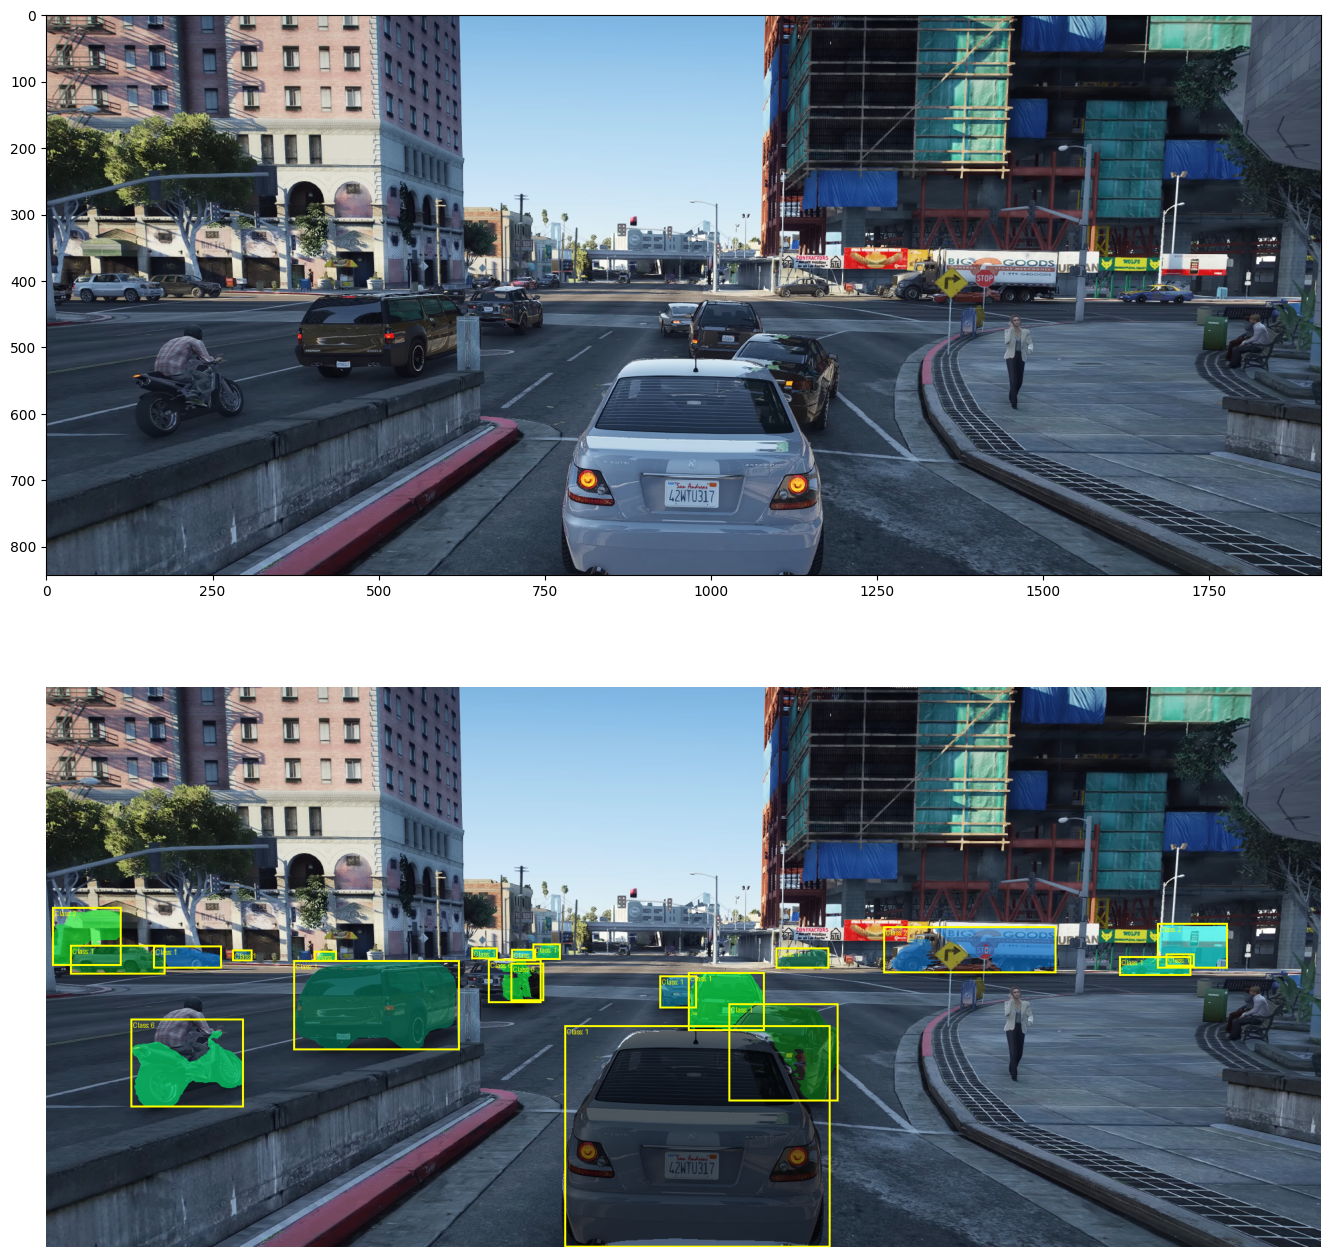

In [5]:
# Get the image
image_name = "gta8.png"
img_path = os.path.join(PATH_IMAGES, image_name)
img_result_path = os.path.join(PATH_RESULT_IMAGES, os.path.splitext(image_name)[0] + '_result.png')

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Process the image
image_processed = process_image(image, model, device, 0.5)

# Save the processed image in the results directory
output_bgr = cv2.cvtColor(image_processed, cv2.COLOR_RGB2BGR)
resultado = cv2.imwrite(img_result_path, output_bgr)

if resultado:
    print("Image saved correctly")
else:
    print("An error ocurred while saving the image")

# Show the results
plt.figure(figsize=(24, 16))
plt.subplot(2,1,1)
plt.imshow(image)
plt.subplot(2,1,2)
plt.imshow(image_processed)
plt.axis('off')
plt.show()

# "car":        1, (0, 0, 142)
# "truck":      2, (0, 0, 70)
# "bus":        3, (0, 60, 100)
# "caravan":    4, (0, 0, 90)
# "trailer":    5, (0, 0, 110)
# "motorcycle": 6, (0, 0, 230)
# "bicycle":    7, (119, 11, 32)

Se puede observar que, pese a que comete algunos errores con los objetos a gran distancia. El modelo detecta y clasifica, perfectamente todos los vehículos de la imagen. En especial del entorno cercano, que es el que más preocupa en el problema del cáclulo de la distancia

## Predicción en vídeo

Ya se ha demostrado el funcionamiento del modelo en imágenes. Ahora se procede a calcular las predicciones para una secuencia de vídeo entera.

In [6]:
def process_video(video_path, output_path, score_threshold=0.5):
    """
        Process a video frame by frame, applying the car segmentation model and saving the result to a new video file.
    Args:
        video_path: Path to the input video in .mp4 format
        output_path: Path to save the processed video in .mp4 format
        score_threshold: The model confidence level needed to draw an instance prediction

    Returns:
        Boolean indicating if the video was processed correctly
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        print(f"Processing video... Resolution: {width}x{height}, FPS: {fps}")
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended
            
            # Process the frame and write it in the ouput route
            processed_frame = process_image(frame, model, device, score_threshold)
            out.write(processed_frame)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", processed_frame)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Liberar recursos
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se procede a mostrar el resultado de aplicar el procesado, a un video de conducción por Los Ángeles. Se despliega también una ventana donde se puede ver el procesado de cada frame a tiempo real

In [7]:
# Get the video capture
video_name = "video2"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result.mp4")

result = process_video(video_path, output_path, score_threshold=0.7)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1560x720, FPS: 24.001465738365702
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/videos\video2_result.mp4


## APLICANDO ROI

A continuación, se define una función que, dada una imagen, dibuja sobre ella las máscaras de segmentación y las bounding boxes etiquetadas con la clase que el modelo a asignado a esa instancia

In [8]:
def draw_predictions(image_tensor, pred_masks, pred_boxes, pred_labels):
    """
        This method draw over a given image the segmentation masks and bounding boxes of given predictions
    Args:
        image_tensor: the image in Tensor format
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class

    Returns:
        processed_image: the image with masks and bounding boxes drawn on it
    """

    # DRAW MASKS
    image_int = (image_tensor * 255).to(torch.uint8)

    # if there are no elements detected, returns the original image
    if len(pred_boxes) == 0:
        return image_int.permute(1, 2, 0).cpu().numpy()

    # Get only the vehicles in the masks
    masks_bool = pred_masks > 0.5
    masks_bool = masks_bool.squeeze(1) 

    # Draw the masks
    if len(masks_bool) > 0:
        processed_image = draw_segmentation_masks(image_int, masks_bool, alpha=0.6, colors="green")
    else:
        processed_image = image_int

    # Draw the bounding boxes
    if len(pred_boxes) > 0:
        labels_text = [f"Class: {label}" for label in pred_labels]
        
        processed_image = draw_bounding_boxes(
            processed_image, 
            pred_boxes, 
            labels=labels_text, 
            colors="yellow", 
            width=3
        )

    processed_image = processed_image.permute(1, 2, 0).cpu().numpy()
    return processed_image

Ahora, se define una función que devuelve las predicciones del modelo, sobre una imagen

In [9]:
def get_predictions(image_tensor, model, score_threshold=0.5):
    """
        This method calculates the predictions of the car segmentation model of a given image,
        and returns the predictions with a confidence level above a given threshold
    Args:
        image: The image to be processed
        model: The model that computes the predictions
        score_threshold: The confidence threshold

    Returns:
        pred_masks: The segmentation masks
        pred_boxes: The bounding boxes
        pred_labels: The labels for each predicted class
    """

    # Turn off gradient mode during the prediction execution
    with torch.no_grad():
        # Get the predictions for that image
        predictions = model([image_tensor])

    prediction = predictions[0]

    # Only keep predictions if the model has a certain level of confidence about them (over 50% score)
    keep_idx = prediction['scores'] > score_threshold

    # If nothing detected, we return the original image
    if not keep_idx.any():
        empty_box = torch.empty((0, 4), device=image_tensor.device)
        empty_mask = torch.empty((0, 1, image_tensor.shape[1], image_tensor.shape[2]), device=image_tensor.device)
        empty_label = torch.empty((0), dtype=torch.int64, device=image_tensor.device)
        return empty_mask, empty_box, empty_label

    pred_boxes = prediction['boxes'][keep_idx]
    pred_masks = prediction['masks'][keep_idx]
    pred_labels = prediction['labels'][keep_idx]

    
    return pred_masks, pred_boxes, pred_labels

Ahora, se va a mostrar el resultado de procesar una imagen tomada del famoso videojuego GTA V.

Saving image to: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/images\gta8_result.png
Image saved correctly


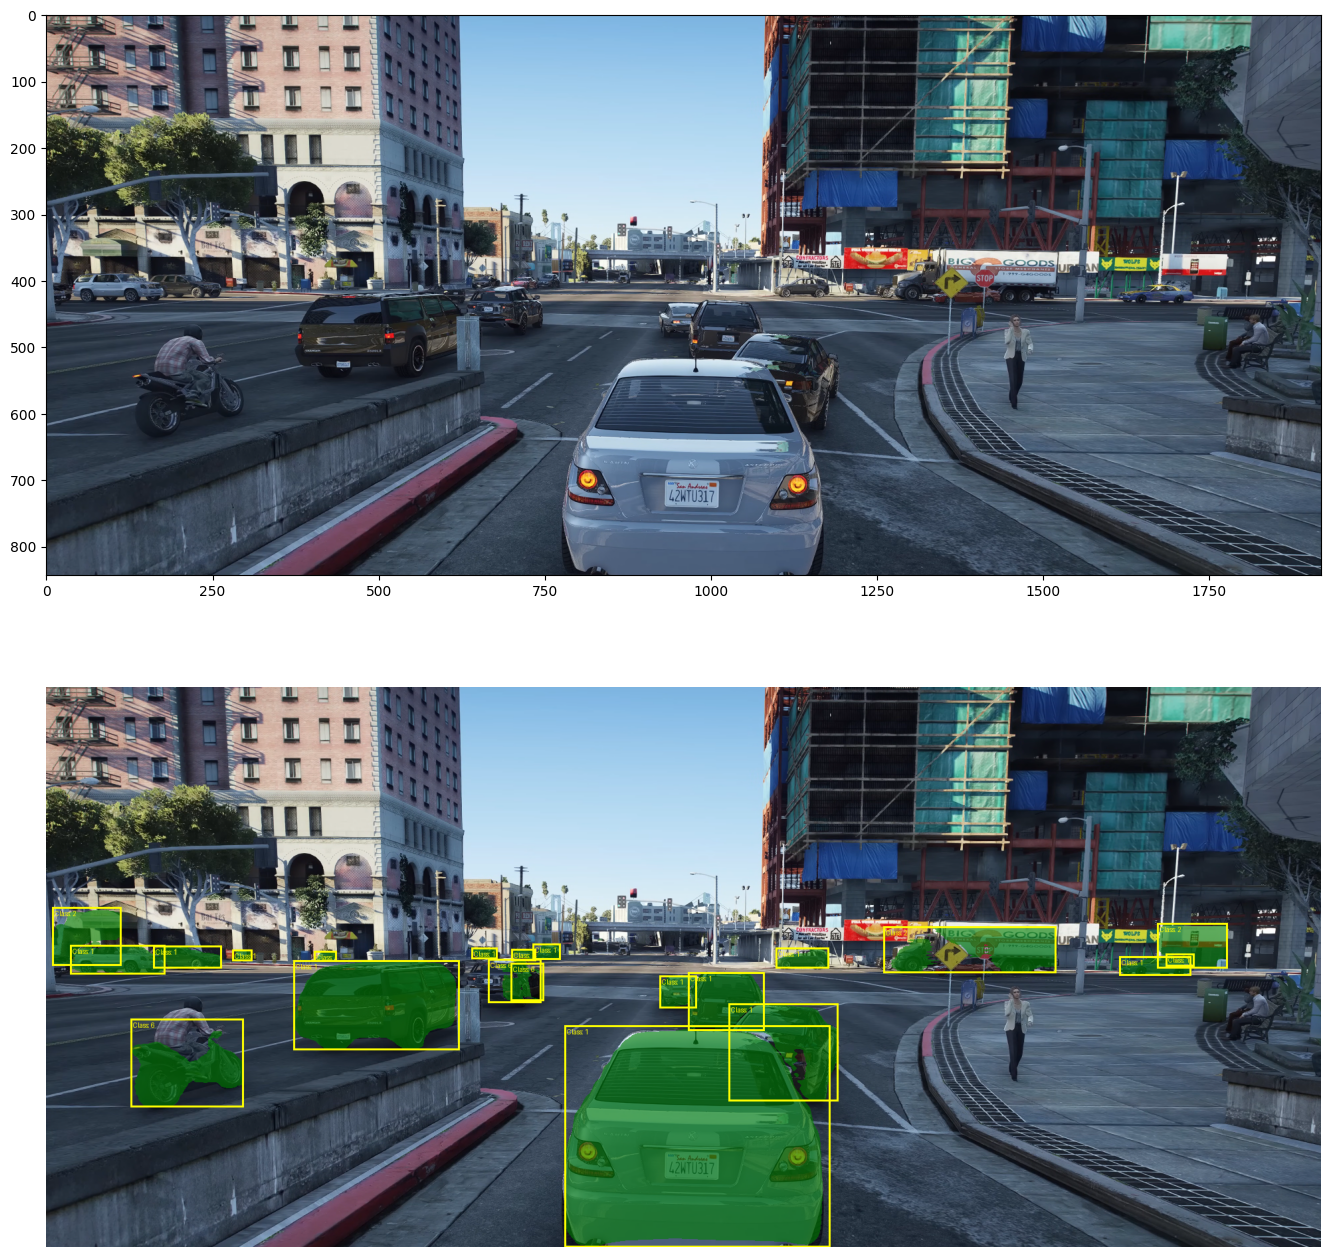

In [10]:
# Get the image
image_name = "gta8.png"
img_path = os.path.join(PATH_IMAGES, image_name)
img_result_path = os.path.join(PATH_RESULT_IMAGES, os.path.splitext(image_name)[0] + '_result.png')

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to Tensor format
image_tensor = F.to_tensor(image).to(device)

pred_masks, pred_boxes, pred_labels = get_predictions(image_tensor, model, 0.5)
image_processed = draw_predictions(image_tensor, pred_masks, pred_boxes, pred_labels)

# Save the processed image in the results directory
output_bgr = cv2.cvtColor(image_processed, cv2.COLOR_RGB2BGR)
print(f"Saving image to: {img_result_path}")
resultado = cv2.imwrite(img_result_path, output_bgr)

if resultado:
    print("Image saved correctly")
else:
    print("An error ocurred while saving the image")

# Show the results
plt.figure(figsize=(24, 16))
plt.subplot(2,1,1)
plt.imshow(image)
plt.subplot(2,1,2)
plt.imshow(image_processed)
plt.axis('off')
plt.show()

# "car":        1, (0, 0, 142)
# "truck":      2, (0, 0, 70)
# "bus":        3, (0, 60, 100)
# "caravan":    4, (0, 0, 90)
# "trailer":    5, (0, 0, 110)
# "motorcycle": 6, (0, 0, 230)
# "bicycle":    7, (119, 11, 32)

Se puede observar que, pese a que comete algunos errores con los objetos a gran distancia. El modelo detecta y clasifica, perfectamente todos los vehículos de la imagen. En especial del entorno cercano, que es el que más preocupa en el problema del cáclulo de la distancia

## Predicción en vídeo

Ya se ha demostrado el funcionamiento del modelo en imágenes. Ahora se procede a calcular las predicciones para una secuencia de vídeo entera.

In [11]:
def process_video(video_path, output_path, model, device='cpu', score_threshold=0.5, frames_per_prediction=1):
    """
        This functions processes a video by calculating the model predictions and draw them on the video

    Args:
        video_path: The path to the video file
        output_path: The path where the resulting video is written
        model: The segmentation model that predicts masks and bouding boxes
        device: The device where the computations will be done. CPU by default
        resize_factor: The resizing apply to the image when calculating predictions. The nearer to zero, the faster the predictions, but results will be worst. Default is 1 (no resizing)
        score_threshold: The asurance of the model for shwoing the instance predictions 
        frames_per_prediction: The amount of frames that passes beetwen each prediction. The smaller, the faster the process, but results will be worst. Default is 1 (every frame)

    Returns:
        true if video is correctly processed, False if an error ocurred.
    """
    # Control frames per second
    if frames_per_prediction <= 0:
        print("Frmes per predictions must be > 0\n")
        return False

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return False
    else:
        # Create Writer with same properties that the original video
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        print(f"Processing video... Resolution: {width}x{height}, FPS: {fps}")
        
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break # Video ended

            # Convert the image to Tensor format
            frame_tensor = F.to_tensor(frame).to(device)
            
            # Only recalculate segmentation each 5 frames (0.16 s with 30 FPS video secuence)
            if frame_count % frames_per_prediction == 0:
                # Process the frame and write it in the ouput route
                pred_masks, pred_boxes, pred_labels = get_predictions(frame_tensor, model, score_threshold)

            frame_processed = draw_predictions(frame_tensor, pred_masks, pred_boxes, pred_labels)
            out.write(frame_processed)
            
            # Show the frame processing in real time
            cv2.imshow("Processed video", frame_processed)
            
            frame_count += 1
            if frame_count % 50 == 0:
                print(f"{frame_count} frames processed...")

            # Exit if press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Liberar recursos
        cap.release()
        out.release()
        cv2.destroyAllWindows()
        return True

Finalmente, se procede a mostrar el resultado de aplicar el procesado, a un video de conducción por Los Ángeles. Se despliega también una ventana donde se puede ver el procesado de cada frame a tiempo real

In [12]:
# Get the video capture
video_name = "video2"
video_path = os.path.join(PATH_VIDEOS, f"{video_name}.mp4")
output_path = os.path.join(PATH_RESULT_VIDEOS,f"{video_name}_result.mp4")

result = process_video(video_path, output_path, model, device, score_threshold=0.7, frames_per_prediction=3)

if result:
    print(f"Video saved in: {output_path}")
else:
    print("An error ocurred while openning the video.")

Processing video... Resolution: 1560x720, FPS: 24.001465738365702
50 frames processed...
Video saved in: c:\Users\gonza\Desktop\universidad\Malaga\Tercero\Vision\Trabajo_Opcional\ADAS-car-distance-prediction\car-distance-prediction\results/car_segmentation/videos\video2_result.mp4


In [73]:
import torch.nn.functional as F

# Supongamos que esta es tu imagen original
# image_original = cv2.imread(...)

def process_with_resize(image_original, model, device, score_threshold=0.5, resize_factor=0.5):
    """
    Args:
        resize_factor: 0.5 significa reducir la imagen a la mitad.
    """
    # 1. Guardar dimensiones originales
    h_orig, w_orig = image_original.shape[:2]
    
    # 2. Calcular nuevas dimensiones y redimensionar imagen para el modelo
    new_w = int(w_orig * resize_factor)
    new_h = int(h_orig * resize_factor)
    
    # Usamos cv2 para redimensionar rápido (baja la carga de CPU)
    image_small = cv2.resize(image_original, (new_w, new_h))
    
    # Preparamos el tensor pequeño
    image_small_rgb = cv2.cvtColor(image_small, cv2.COLOR_BGR2RGB)
    image_tensor_small = F.to_tensor(image_small_rgb).to(device)
    
    # 3. OBTENER PREDICCIONES (en coordenadas pequeñas)
    pred_masks, pred_boxes, pred_labels = get_predictions(image_tensor_small, model, score_threshold)
    
    # Si no hay detecciones, devolvemos la original sin pintar
    if len(pred_boxes) == 0:
        return image_original

    # 4. RE-ESCALAR PREDICCIONES AL TAMAÑO ORIGINAL
    
    # A) Escalar Cajas (Bounding Boxes)
    # Multiplicamos las coordenadas por la inversa del factor (ej: si redujimos x0.5, multiplicamos x2)
    scale = 1 / resize_factor
    pred_boxes_scaled = pred_boxes * scale
    
    # B) Escalar Máscaras
    # Las máscaras son mapas de bits, hay que interpolarlas (redimensionarlas)
    # interpolate espera entrada 4D: (Batch, Channels, Height, Width)
    # pred_masks tiene forma (N, 1, h_small, w_small)
    pred_masks_scaled = F.interpolate(
        pred_masks, 
        size=(h_orig, w_orig), 
        mode="bilinear", 
        align_corners=False
    )
    
    # 5. DIBUJAR (Usando la imagen ORIGINAL y las predicciones ESCALADAS)
    # Convertimos la original a tensor para poder usar tu función de dibujo
    image_orig_tensor = F.to_tensor(cv2.cvtColor(image_original, cv2.COLOR_BGR2RGB))
    
    # Llamamos a tu función de dibujo con los datos ya ajustados
    final_image = draw_predictions2(
        image_orig_tensor, 
        pred_masks_scaled, 
        pred_boxes_scaled, 
        pred_labels
    )
    
    # Convertir a BGR para OpenCV (si draw_predictions2 devolvía RGB)
    final_image_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)
    
    return final_image_bgr